In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib as plt
import random
from sklearn.utils import shuffle
import pickle

In [2]:
ds, ds_info = tfds.load('omniglot', split=['train[:80%]','test'],with_info=True, as_supervised = False)
ds_info

Metal device set to: Apple M1 Pro


2022-05-12 11:15:07.603070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 11:15:07.603159: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


tfds.core.DatasetInfo(
    name='omniglot',
    full_name='omniglot/3.0.0',
    description="""
    Omniglot data set for one-shot learning. This dataset contains 1623 different
    handwritten characters from 50 different alphabets.
    """,
    homepage='https://github.com/brendenlake/omniglot/',
    data_path='/Users/brendanwallace-nash/tensorflow_datasets/omniglot/3.0.0',
    download_size=17.95 MiB,
    dataset_size=12.29 MiB,
    features=FeaturesDict({
        'alphabet': ClassLabel(shape=(), dtype=tf.int64, num_classes=50),
        'alphabet_char_id': tf.int64,
        'image': Image(shape=(105, 105, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=1623),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'small1': <SplitInfo num_examples=2720, num_shards=1>,
        'small2': <SplitInfo num_examples=3120, num_shards=1>,
        'test': <SplitInfo num_examples=13180, num_shards=1>,
        'tra

In [3]:
#test = pickle.load(open("TestDF_ds.pickle", "rb"))
#train = pickle.load(open("TrainDF_ds.pickle", "rb"))

In [4]:
#len(ds[0])

In [5]:
#len(ds[1])

In [6]:
trainDF = tfds.as_dataframe(ds[0])
testDF = tfds.as_dataframe(ds[1])

2022-05-12 11:15:07.656505: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
trainDF = trainDF[:8000]
testDF = testDF[:2000]

In [8]:
def make_positive_pairs(df):
    
    list_image = []    
    pairList= []
    
    uniqueAlph = df['alphabet'].unique()
    
    for i in range(len(uniqueAlph)):
        alphDF = df[df['alphabet'] == i]
        charUnique = alphDF['alphabet_char_id'].unique()
        for i in range(len(charUnique)):
            dfImage = alphDF[alphDF['alphabet_char_id'] == charUnique[i]]
            
            imagedf = dfImage['image'].copy()
            imageList = imagedf.values.tolist()
            
            
            list_image.append(imageList[0])
            
        x = 0 
        pair_list = []
        pair_target = []
        list_image2 = list_image.copy()
        for i in range(len(list_image)):
            for x in range(len(list_image)):
                pair_list.append([list_image[i], list_image2[x]])
                pair_target.append(1.0)
                
                
        random.shuffle(pair_list)       
        
            
            
            
    return pair_list, pair_target
        

In [9]:
def get_pairs(data):
        
    
    df = data.sort_values(by=['alphabet'])
    
    df_pairs_1 = df[df.index % 2 != 0]
    
    df_pairs_2 = df[df.index % 2 != 1]
    
    df_pairs_1 = shuffle(df_pairs_1)
    
    imagedf = df_pairs_1['image'].copy()
    imageList = imagedf.values.tolist()
    
    alphabetdf = df_pairs_1['alphabet'].copy()
    alphabetList = alphabetdf.values.tolist()
    
    imagedf2 = df_pairs_2['image'].copy()
    imageList2 = imagedf.values.tolist()
    
    alphabetdf2 = df_pairs_2['alphabet'].copy()
    alphabetList2 = alphabetdf.values.tolist()
    
    imageList2 = shuffle(imageList2)
    imageList = shuffle(imageList)
    alphabetList = shuffle(alphabetList)
    alphabetList2 = shuffle(alphabetList2)
    
    trainList = []
    testList = []
    
    for i in range(len(alphabetList)):
        loopList = []
        pos = 1.0
        neg = 0.0
        if alphabetList[i] == alphabetList2[i]:
            loopList.append(imageList[i].astype(float))
            loopList.append(imageList2[i].astype(float))
            testList.append(pos)
            trainList.append(loopList)
        else:
            loopList.append(imageList[i].astype(float))
            loopList.append(imageList2[i].astype(float))
            testList.append(neg)
            trainList.append(loopList)
    
    return trainList, testList

In [10]:
def count_neg_pairs(list_bin):
    x = 1
    count = []
    for i in range(len(list_bin)):
        if list_bin[i] == 0.0:
            count.append(x)
        else:
            pass
    print(len(count))

In [11]:
def combine_pairs(train1, test1, train2, test2):
    for i in range(len(train2)):
        train1.append(train2[i])
    
    
    for i in range(len(test2)):
        test1.append(test2[i])
    
    shuffleList = list(zip(train1, test1))
                       
    random.shuffle(shuffleList)
    
    train1, test1 = zip(*shuffleList)
                       
    train1 = np.array(train1)
    test1 = np.array(test1)
    
    train1/225

    
    return train1, test1

In [12]:
trainX, trainY = get_pairs(trainDF)

In [13]:
count_neg_pairs(trainY)

3860


In [14]:
trainXPos, trainYPos = make_positive_pairs(trainDF)

In [15]:
trainXPos = trainXPos[0:20000]

In [16]:
trainYPos = trainYPos[0:20000]

In [17]:
trainXFinal, trainYFinal= combine_pairs(trainXPos, trainYPos, trainX, trainY)

In [18]:
len(trainYFinal)

24000

In [19]:
len(trainXFinal)

24000

In [20]:
#trainYFinal = trainYFinal.reshape(69640, 1)

In [21]:
count_neg_pairs(trainYFinal)

3860


test data preprocessing

In [22]:
testX, testY = get_pairs(testDF)

In [23]:
count_neg_pairs(testY)

944


In [24]:
testXPos, testYPos = make_positive_pairs(testDF)

In [25]:
testXFinal, testYFinal= combine_pairs(testXPos, testYPos, testX, testY)

In [26]:
temp = list(zip(testXFinal, testYFinal))
random.shuffle(temp)
testXFinal, testYFinal = zip(*temp)

In [27]:
testXFinal = testXFinal[:5000]
testYFinal = testYFinal[:5000]

In [28]:
'''
import pickle
pickle_out = open("trainXFinal.pickle", "wb")
pickle.dump(trainXFinal, pickle_out)
pickle_out.close()

pickle_out = open("trainYPos.pickle", "wb")
pickle.dump(trainYPos, pickle_out)
pickle_out.close()

pickle_out = open("testXFinal.pickle", "wb")
pickle.dump(testXFinal, pickle_out)
pickle_out.close()

pickle_out = open("testYFinal.pickle", "wb")
pickle.dump(testYFinal, pickle_out)
pickle_out.close()


'''

'\nimport pickle\npickle_out = open("trainXFinal.pickle", "wb")\npickle.dump(trainXFinal, pickle_out)\npickle_out.close()\n\npickle_out = open("trainYPos.pickle", "wb")\npickle.dump(trainYPos, pickle_out)\npickle_out.close()\n\npickle_out = open("testXFinal.pickle", "wb")\npickle.dump(testXFinal, pickle_out)\npickle_out.close()\n\npickle_out = open("testYFinal.pickle", "wb")\npickle.dump(testYFinal, pickle_out)\npickle_out.close()\n\n\n'

In [29]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
#import wandb
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, Lambda, Dot
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

In [30]:
#X_train, X_test, y_train, y_test = train_test_split(trainXFinal, trainYFinal, test_size=0.20, random_state=42)


In [31]:
lenX = round(len(trainXFinal)*0.20)
lenY = round(len(trainYFinal)*0.20)
X_train = trainXFinal[lenX:]
X_test = trainYFinal[lenX:]
y_train = trainXFinal[:lenY]
y_test = trainYFinal[:lenY]

In [32]:
len(y_train)

4800

In [33]:
epochs = 20
batch_size = 128
margin = 1  # Margin for constrastive loss.

In [34]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((105, 105, 3))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(16, (3, 3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(64, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((105, 105, 3))
input_2 = layers.Input((105, 105, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [35]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [36]:
siamese.compile(loss=loss(margin=margin), optimizer="Adam", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 64)           1258540     ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [37]:
history = siamese.fit(
    [X_train[:,0], X_train[:,1]],
    X_test[:],
    validation_data=([y_train[:,0], y_train[:,1]], y_test[:]),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20


2022-05-12 11:15:42.628978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - ETA: 0s - loss: 0.2435 - accuracy: 0.5633

2022-05-12 11:15:56.368166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 15s 90ms/step - loss: 0.2435 - accuracy: 0.5633 - val_loss: 0.2940 - val_accuracy: 0.3713
Epoch 2/20
150/150 [==============================] - 12s 77ms/step - loss: 0.1908 - accuracy: 0.7688 - val_loss: 0.1550 - val_accuracy: 0.8273
Epoch 3/20
150/150 [==============================] - 11s 77ms/step - loss: 0.1381 - accuracy: 0.8921 - val_loss: 0.1652 - val_accuracy: 0.7971
Epoch 4/20
150/150 [==============================] - 12s 77ms/step - loss: 0.0983 - accuracy: 0.9349 - val_loss: 0.1202 - val_accuracy: 0.8631
Epoch 5/20
150/150 [==============================] - 11s 76ms/step - loss: 0.0709 - accuracy: 0.9558 - val_loss: 0.1134 - val_accuracy: 0.8598
Epoch 6/20
150/150 [==============================] - 11s 76ms/step - loss: 0.0521 - accuracy: 0.9702 - val_loss: 0.0967 - val_accuracy: 0.8810
Epoch 7/20
150/150 [==============================] - 11s 77ms/step - loss: 0.0371 - accuracy: 0.9810 - val_loss: 0.1009 - val_accuracy: 0.8698
Epo

In [38]:
y_train[0][0] = y_train[0][0].reshape(-1, 105, 105, 3)

In [39]:
y_train[0][1] = y_train[0][1].reshape(-1, 105, 105, 3)

In [40]:
prediction = siamese.predict([y_train[:, 0].reshape(-1, 105, 105, 3), y_train[:, 1].reshape(-1, 105, 105, 3)])

2022-05-12 11:19:36.297203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [41]:
def get_result(X_value, y_value):
    predictions = []
    counts = 0
    for i in range(len(X_value)):
        prediction = siamese.predict([X_value[i][0].reshape(-1, 105, 105, 3), X_value[i][1].reshape(-1, 105, 105, 3)])
        if prediction > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    for i in range(len(X_value)):
        if predictions[i] == y_value[i]:
            counts = counts+1
    accuracy = (counts/len(X_value))*100
    return accuracy

In [42]:
test_acc = get_result(testXFinal, testYFinal)

2022-05-12 11:19:37.593898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [44]:
train_acc = get_result(trainXFinal, trainYFinal)

In [47]:
print("train accuracy is {}%".format(train_acc))

train accuracy is 90.73333333333333%


In [48]:
print("test accuracy is {}%".format(test_acc))

test accuracy is 81.74%


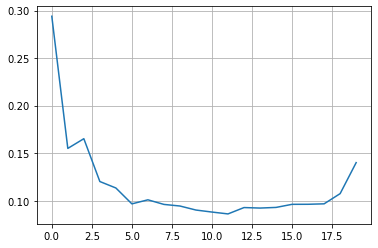

In [50]:
#valadation loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.grid(True)
plt.show()

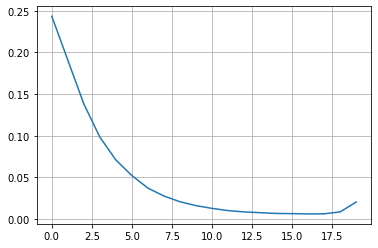

In [51]:
#Loss over epochs 
plt.plot(history.history['loss'], label='Loss')
plt.grid(True)
plt.show()